In [1]:
import pandas as pd
import csv
import numpy as np

df = pd.read_csv("Dataset(LabelEncoder).csv", low_memory=False)
df

,label,file_access,pe_imports,sig_clamav,pe_sec_character,sig_antivirus_virustotal,cmd_exec,api_resolv,pe_sec_entropy,pe_sec_name,...,sig_antianalysis_detectfile,sig_network_cnc_http,sig_removes_zoneid_ads,sig_downloader_cabby,sig_sniffer_winpcap,sig_creates_largekey,sig_infostealer_bitcoin,sig_static_detection,sig_antiav_servicestop,sig_recon_beacon
0,0,764,129,560,81,2280,102,1302,1147,211,...,2,12,5,2,2,3,0,231,4,11
1,0,984,129,560,81,2018,112,1302,1147,211,...,2,12,5,2,2,3,0,231,4,11
2,0,2164,1394,560,77,2018,541,237,124,207,...,2,12,5,2,2,3,0,231,4,11
3,0,946,962,560,81,2214,527,1212,183,211,...,2,12,5,2,2,3,0,231,4,11
4,0,1743,1345,560,77,216,144,634,73,207,...,2,12,5,2,2,3,0,231,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6027,4,561,1235,560,88,1447,541,634,1741,222,...,2,12,5,2,2,3,0,174,4,11
6028,4,1341,978,560,88,422,541,634,1138,222,...,2,12,5,2,2,3,0,152,4,11
6029,4,561,1235,560,88,1447,541,634,1741,222,...,2,12,5,2,2,3,0,174,4,11
6030,4,1846,465,560,107,954,541,634,1787,233,...,2,12,5,2,2,3,0,231,4,11


In [2]:
from sklearn.model_selection import train_test_split

# Separating the features from the target variable
X = df.iloc[:, 1:65]
y = df['label']

# Splitting the data into a train and a dev set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0) 

In [3]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='gini',max_depth=10, max_features='sqrt',
                             min_samples_split=10, n_estimators=300, random_state=0)

boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=0)

boruta_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	64
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	23
Tentative: 	4
Rejected: 	37
Iteration: 	9 / 100
Confirmed: 	23
Tentative: 	4
Rejected: 	37
Iteration: 	10 / 100
Confirmed: 	23
Tentative: 	4
Rejected: 	37
Iteration: 	11 / 100
Confirmed: 	23
Tentative: 	4
Rejected: 	37
Iteration: 	12 / 100
Confirmed: 	23
Tentative: 	1
Rejected: 	40
Iteration: 	13 / 100
Confirmed: 	23
Tentative: 	1
Rejected: 	40
Iteration: 	14 / 100
Confirmed: 	23
Tentative: 	1
Rejected: 	40
Iteration: 	15 / 100
Confirmed: 	23
Tentative: 	1
Rejected: 	40
Iteration: 	16 / 100
Confirmed: 	24
Tentative: 	0
Reject

BorutaPy(estimator=RandomForestClassifier(max_depth=10, min_samples_split=10,
                                          n_estimators=69,
                                          random_state=RandomState(MT19937) at 0x14C12CA1140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x14C12CA1140, verbose=2)

In [4]:
# Using the BorutaPy object to transform the features in the dataset.
X_important_train = boruta_selector.transform(np.array(X_train))
X_important_test = boruta_selector.transform(np.array(X_test)) 

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_boruta = RandomForestClassifier(random_state=0)

# Defining search space from which grid serch will select a model which will give the best result.
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [200, 300, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5, 10]
}

# Making an object grid_GBC for GridSearchCV and fitting the dataset
grid_rf = GridSearchCV(rf_boruta, param_grid, refit=True, n_jobs=-1, cv=10, verbose=3, scoring='accuracy')
grid_rf.fit(X_important_train, y_train)

# Print best parameters and accuracy score
print("Best parameters found: ", grid_rf.best_params_)
print("Best accuracy score found: {:.4f}".format(grid_rf.best_score_))

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}
Best accuracy score found: 0.7865


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate model
rfc1 = RandomForestClassifier(criterion='gini',max_depth=10, max_features='sqrt',
                              min_samples_split=10, n_estimators=300, random_state=0)

# Train the model on training data
rfc1.fit(X_important_train, y_train)

# Use the forest's predict method on the test data
rfc_predict = rfc1.predict(X_important_test)

# Export the predicted values
np.savetxt("RF_Imbalanced(80-20).csv", rfc_predict, delimiter=",")

In [6]:
from sklearn import metrics

# Accuracy
print(metrics.accuracy_score(y_test, rfc_predict))
# Precision
print(metrics.precision_score(y_test, rfc_predict, average='weighted'))
# Recall
print(metrics.recall_score(y_test, rfc_predict, average='weighted'))
# F1 Score
print(metrics.f1_score(y_test, rfc_predict, average='weighted'))

0.7978458989229494
0.8230034260589963
0.7978458989229494
0.7949422365145308


C:\Users\user\AppData\Local\Temp\ipykernel_9520\3015791322.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
C:\Users\user\AppData\Local\Temp\ipykernel_9520\3015791322.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(b)


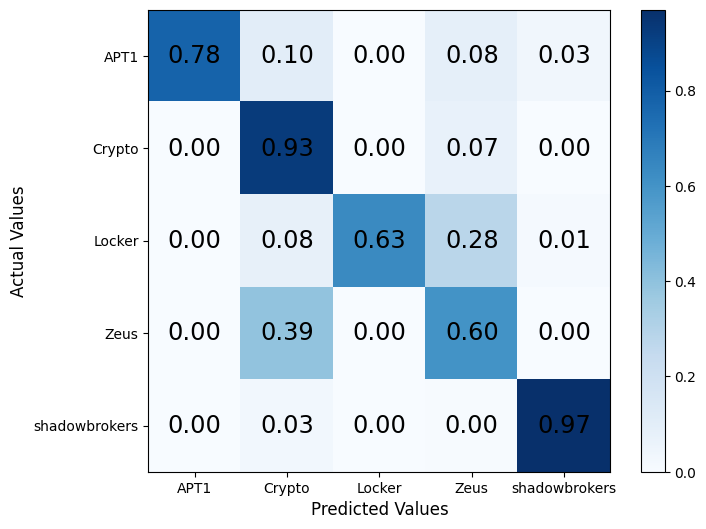

In [11]:
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, rfc_predict, normalize = 'true')

fig, ax = plt.subplots(figsize=(8, 6))
caxes = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(caxes)
fmt = '.2f'
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=format(conf_matrix[i, j], fmt), va='center', ha='center', size='xx-large')

a=ax.get_xticks().tolist()
a[1]='APT1'
a[2]='Crypto'
a[3]='Locker'
a[4]='Zeus'
a[5]='shadowbrokers'

b=ax.get_yticks().tolist()
b[1]='APT1'
b[2]='Crypto'
b[3]='Locker'
b[4]='Zeus'
b[5]='shadowbrokers'
ax.set_xticklabels(a)
ax.set_yticklabels(b)

plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Actual Values', fontsize=12)
plt.gca().xaxis.tick_bottom()
plt.show()

In [7]:
# Instantiate model with 100 decision trees
rfc2 = RandomForestClassifier(criterion='gini',max_depth=10, max_features='sqrt',
                              min_samples_split=10, n_estimators=300, random_state=0)

# Train the model on training data
rfc2.fit(X_train, y_train)

# Use the forest's predict method on the test data
rfc2_predict = rfc2.predict(X_test)

# Export the predicted values
np.savetxt("RF_ImbalancedXBoruta(80-20).csv", rfc2_predict, delimiter=",")

In [9]:
from sklearn import metrics

# Accuracy
print(metrics.accuracy_score(y_test, rfc2_predict))
# Precision
print(metrics.precision_score(y_test, rfc2_predict, average='weighted'))
# Recall
print(metrics.recall_score(y_test, rfc2_predict, average='weighted'))
# F1 Score
print(metrics.f1_score(y_test, rfc2_predict, average='weighted'))

0.7854183927091963
0.8078743675709713
0.7854183927091963
0.7826458599914604


C:\Users\user\AppData\Local\Temp\ipykernel_9520\4042831572.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)
C:\Users\user\AppData\Local\Temp\ipykernel_9520\4042831572.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(b)


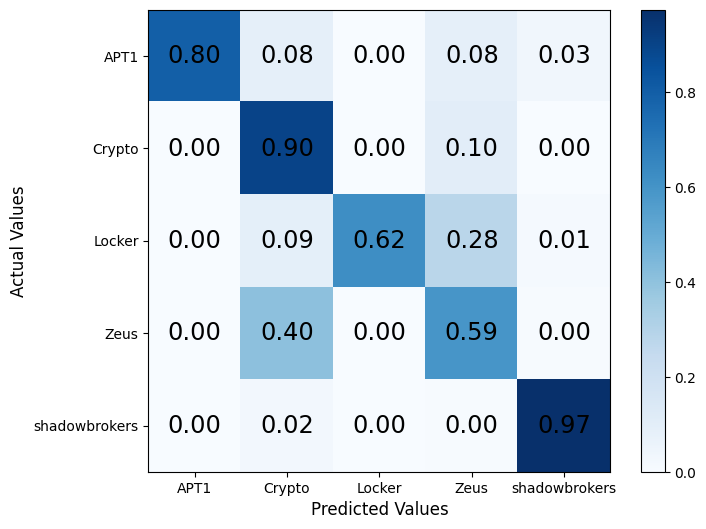

In [13]:
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix2 = metrics.confusion_matrix(y_test, rfc2_predict, normalize = 'true')

fig, ax = plt.subplots(figsize=(8, 6))
caxes = ax.matshow(conf_matrix2, cmap=plt.cm.Blues)
fig.colorbar(caxes)
fmt = '.2f'
for i in range(conf_matrix2.shape[0]):
    for j in range(conf_matrix2.shape[1]):
        ax.text(x=j, y=i,s=format(conf_matrix2[i, j], fmt), va='center', ha='center', size='xx-large')

a=ax.get_xticks().tolist()
a[1]='APT1'
a[2]='Crypto'
a[3]='Locker'
a[4]='Zeus'
a[5]='shadowbrokers'

b=ax.get_yticks().tolist()
b[1]='APT1'
b[2]='Crypto'
b[3]='Locker'
b[4]='Zeus'
b[5]='shadowbrokers'
ax.set_xticklabels(a)
ax.set_yticklabels(b)

plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Actual Values', fontsize=12)
plt.gca().xaxis.tick_bottom()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_9520\2680982655.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(a)
C:\Users\user\AppData\Local\Temp\ipykernel_9520\2680982655.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(b)
C:\Users\user\AppData\Local\Temp\ipykernel_9520\2680982655.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(a)
C:\Users\user\AppData\Local\Temp\ipykernel_9520\2680982655.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(b)


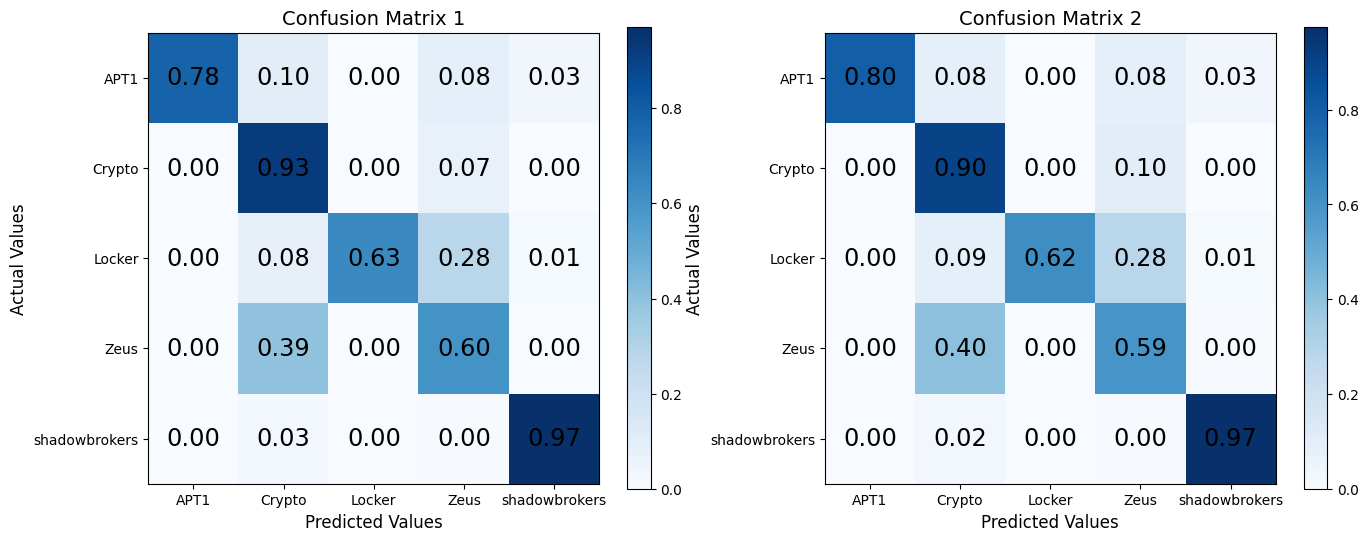

In [20]:
# Confusion Matrix 1
conf_matrix = metrics.confusion_matrix(y_test, rfc_predict, normalize='true')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Confusion Matrix 1
im1 = ax[0].matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(im1, ax=ax[0])
fmt = '.2f'
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax[0].text(x=j, y=i, s=format(conf_matrix[i, j], fmt), va='center', ha='center', size='xx-large')

a = ax[0].get_xticks().tolist()
a[1] = 'APT1'
a[2] = 'Crypto'
a[3] = 'Locker'
a[4] = 'Zeus'
a[5] = 'shadowbrokers'

b = ax[0].get_yticks().tolist()
b[1] = 'APT1'
b[2] = 'Crypto'
b[3] = 'Locker'
b[4] = 'Zeus'
b[5] = 'shadowbrokers'
ax[0].set_xticklabels(a)
ax[0].set_yticklabels(b)

ax[0].set_xlabel('Predicted Values', fontsize=12)
ax[0].set_ylabel('Actual Values', fontsize=12)
ax[0].xaxis.tick_bottom()
ax[0].set_title('Confusion Matrix ', fontsize=14)

# Confusion Matrix 2
conf_matrix2 = metrics.confusion_matrix(y_test, rfc2_predict, normalize='true')

# Plotting Confusion Matrix 2
im2 = ax[1].matshow(conf_matrix2, cmap=plt.cm.Blues)
fig.colorbar(im2, ax=ax[1])
for i in range(conf_matrix2.shape[0]):
    for j in range(conf_matrix2.shape[1]):
        ax[1].text(x=j, y=i, s=format(conf_matrix2[i, j], fmt), va='center', ha='center', size='xx-large')

ax[1].set_xticklabels(a)
ax[1].set_yticklabels(b)

ax[1].set_xlabel('Predicted Values', fontsize=12)
ax[1].set_ylabel('Actual Values', fontsize=12)
ax[1].xaxis.tick_bottom()
ax[1].set_title('Confusion Matrix 2', fontsize=14)  # Add title for Confusion Matrix 2

plt.show()